In [1]:
import os
import pandas as pd
import numpy as ny
import tensorflow as tf

In [4]:
df=pd.read_csv(os.path.join('DatasetForCommentsReading','twitter_data.csv'))

In [5]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [60]:
#pre processing

In [6]:
from tensorflow.keras.layers import TextVectorization

In [17]:
x=df['comment_text']
y=df[df.columns[2:]].values
x,y

(0         Explanation\nWhy the edits made under my usern...
 1         D'aww! He matches this background colour I'm s...
 2         Hey man, I'm really not trying to edit war. It...
 3         "\nMore\nI can't make any real suggestions on ...
 4         You, sir, are my hero. Any chance you remember...
                                 ...                        
 159566    ":::::And for the second time of asking, when ...
 159567    You should be ashamed of yourself \n\nThat is ...
 159568    Spitzer \n\nUmm, theres no actual article for ...
 159569    And it looks like it was actually you who put ...
 159570    "\nAnd ... I really don't think you understand...
 Name: comment_text, Length: 159571, dtype: object,
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [18]:
vectorizer=TextVectorization(max_tokens=200000,output_sequence_length=1800,output_mode='int')
vectorizer.adapt(x.values)
vectorized_text=vectorizer(x.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [19]:
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(16000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)

In [20]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
### CREATING MODEL

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [24]:
model=Sequential()
model.add(Embedding(200001,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))

In [25]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
training=model.fit(train,epochs=1,validation_data=val)

5333/6981 [=====================>........] - ETA: 32:37 - loss: 0.0206

In [53]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

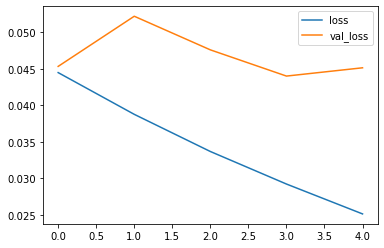

In [54]:
plt.figure(figsize=(8,5))
pd.DataFrame(training.history).plot()
plt.show()

In [55]:
### PREDICTION

In [56]:
#test_input=vectorizer('you love!')
batch=test.as_numpy_iterator().next()
batch_x, batch_y =test.as_numpy_iterator().next()
(model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 0s 236ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [57]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [58]:
### EVALUATE MODEL

In [59]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [60]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [70]:
for batch in test.as_numpy_iterator():
    x_true, y_true=batch
    yhat=model.predict(x_true)
    y_true=y_true.flatten()
    yhat=yhat.flatten()
    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 225ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 224ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 248ms/step


In [71]:
print(f'precision:{pre.result().numpy()}, recall:{re.result().numpy()}, accuracy:{acc.result().numpy()}')

precision:0.7294307947158813, recall:0.757529079914093, accuracy:0.4468405246734619


In [72]:
###gradio

In [73]:
import gradio as gr

In [74]:
model.save('cyber_bulliyng_detect.h5')
model=tf.keras.models.load_model('cyber_bulliyng_detect.h5')

In [68]:
def check_comment(comment):
    vectorized_comment=vectorizer([comment])
    result=model.predict(vectorized_comment)
    text=''
    for idx, col in enumerate(df.columns[2:]):
         text +='{}: {}\n'.format(col, result[0][idx]>0.5)

    return text

In [69]:
interface=gr.Interface(fn=check_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='comment to check'), outputs='text')
interface.launch(share=False)

C:\Users\deepanshu panwar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\deepanshu panwar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\deepanshu panwar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7864/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x2d4332402e0>, 'http://127.0.0.1:7864/', None)

1/1 [==============================] - 0s 120ms/step


In [47]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')